In [1]:
import ROOT
import os
from dask.distributed import Client
distributed = True
nmaxpartitions = 75
sched_port = 25003
MT = False

Error in <TExMap::Add>: key 140530929892832 is not unique
Error in <TExMap::Add>: key 140530930409424 is not unique
TClassTable::Add:0: RuntimeWarning: class timespec already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<TString*,vector<TString> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<int*,vector<int> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<string*,vector<string> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__no

Welcome to JupyROOT 6.25/01


In [2]:
if distributed != True and MT == True:
    ROOT.ROOT.EnableImplicitMT()

# Import utils functions

In [3]:
def my_initialization_function():
    ROOT.gInterpreter.Declare('{}'.format(data))

In [4]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [5]:
if distributed == True:
    RDataFrame = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame
    client = Client(address="tcp://127.0.0.1:"+str(sched_port))
    text_file = open("postselection.h", "r")
    data = text_file.read()
    ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)

else:
    RDataFrame = ROOT.RDataFrame
    ROOT.gInterpreter.Declare('#include "postselection.h"')

/opt/conda/lib/python3.9/site-packages/distributed/client.py:1123: VersionMismatchWarning: Mismatched versions found

+-------------+-----------+-----------+-----------+
| Package     | client    | scheduler | workers   |
+-------------+-----------+-----------+-----------+
| dask        | 2021.09.1 | 2021.09.0 | 2021.09.0 |
| distributed | 2021.09.1 | 2021.09.0 | 2021.09.0 |
| numpy       | 1.20.3    | 1.21.2    | 1.21.2    |
| pandas      | 1.3.4     | 1.3.3     | 1.3.3     |
+-------------+-----------+-----------+-----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
input_line_49:688:1: warning: control may reach end of non-void function [-Wreturn-type]
}
^


In [6]:
sampleDict = {'WpWpJJ_EWK_2017': 0, 'WpWpJJ_QCD_2017': 1, 'VBS_SSWW_SM_2017': 2, 'VBS_SSWW_LL_SM_2017': 3, 'VBS_SSWW_TL_SM_2017': 4, 'VBS_SSWW_TT_SM_2017': 5, 'VBS_SSWW_cHW_2017': 6, 'VBS_SSWW_cHW_BSM_2017': 7, 'VBS_SSWW_cHW_INT_2017': 8, 'VBS_SSWW_cW_2017': 9, 'VBS_SSWW_cW_BSM_2017': 10, 'VBS_SSWW_cW_INT_2017': 11, 'VBS_SSWW_cW_cHW_2017': 12, 'VBS_SSWW_DIM6_2017': 13, 'VBS_SSWW_DIM6_SM_2017': 14, 'VBS_SSWW_cHW_SM_2017': 15, 'VBS_SSWW_cW_SM_2017': 16, 'VBS_SSWW_aQGC_2017': 17, 'VBS_SSWW_FS0_25_BSM_2017': 18, 'VBS_SSWW_FS0_25_INT_2017': 19, 'VBS_SSWW_FS0_25_SM_2017': 20, 'VBS_SSWW_FS0_25_2017': 21, 'VBS_SSWW_FS0_5_BSM_2017': 22, 'VBS_SSWW_FS0_5_INT_2017': 23, 'VBS_SSWW_FS0_5_SM_2017': 24, 'VBS_SSWW_FS0_5_2017': 25, 'VBS_SSWW_FS0_0_2017': 26, 'VBS_SSWW_FS1_50_BSM_2017': 27, 'VBS_SSWW_FS1_50_INT_2017': 28, 'VBS_SSWW_FS1_50_SM_2017': 29, 'VBS_SSWW_FS1_50_2017': 30, 'VBS_SSWW_FS1_10_BSM_2017': 31, 'VBS_SSWW_FS1_10_INT_2017': 32, 'VBS_SSWW_FS1_10_SM_2017': 33, 'VBS_SSWW_FS1_10_2017': 34, 'VBS_SSWW_FS1_0_2017': 35, 'VBS_SSWW_FM0_25_BSM_2017': 36, 'VBS_SSWW_FM0_25_INT_2017': 37, 'VBS_SSWW_FM0_25_SM_2017': 38, 'VBS_SSWW_FM0_25_2017': 39, 'VBS_SSWW_FM0_5_BSM_2017': 40, 'VBS_SSWW_FM0_5_INT_2017': 41, 'VBS_SSWW_FM0_5_SM_2017': 42, 'VBS_SSWW_FM0_5_2017': 43, 'VBS_SSWW_FM0_0_2017': 44, 'VBS_SSWW_FM1_25_BSM_2017': 45, 'VBS_SSWW_FM1_25_INT_2017': 46, 'VBS_SSWW_FM1_25_SM_2017': 47, 'VBS_SSWW_FM1_25_2017': 48, 'VBS_SSWW_FM1_5_BSM_2017': 49, 'VBS_SSWW_FM1_5_INT_2017': 50, 'VBS_SSWW_FM1_5_SM_2017': 51, 'VBS_SSWW_FM1_5_2017': 52, 'VBS_SSWW_FM1_0_2017': 53, 'VBS_SSWW_FM6_25_BSM_2017': 54, 'VBS_SSWW_FM6_25_INT_2017': 55, 'VBS_SSWW_FM6_25_SM_2017': 56, 'VBS_SSWW_FM6_25_2017': 57, 'VBS_SSWW_FM6_5_BSM_2017': 58, 'VBS_SSWW_FM6_5_INT_2017': 59, 'VBS_SSWW_FM6_5_SM_2017': 60, 'VBS_SSWW_FM6_5_2017': 61, 'VBS_SSWW_FM6_0_2017': 62, 'VBS_SSWW_FM7_50_BSM_2017': 63, 'VBS_SSWW_FM7_50_INT_2017': 64, 'VBS_SSWW_FM7_50_SM_2017': 65, 'VBS_SSWW_FM7_50_2017': 66, 'VBS_SSWW_FM7_10_BSM_2017': 67, 'VBS_SSWW_FM7_10_INT_2017': 68, 'VBS_SSWW_FM7_10_SM_2017': 69, 'VBS_SSWW_FM7_10_2017': 70, 'VBS_SSWW_FM7_0_2017': 71, 'VBS_SSWW_FT0_2p5_BSM_2017': 72, 'VBS_SSWW_FT0_2p5_INT_2017': 73, 'VBS_SSWW_FT0_2p5_SM_2017': 74, 'VBS_SSWW_FT0_2p5_2017': 75, 'VBS_SSWW_FT0_0p5_BSM_2017': 76, 'VBS_SSWW_FT0_0p5_INT_2017': 77, 'VBS_SSWW_FT0_0p5_SM_2017': 78, 'VBS_SSWW_FT0_0p5_2017': 79, 'VBS_SSWW_FT0_0_2017': 80, 'VBS_SSWW_FT1_1_BSM_2017': 81, 'VBS_SSWW_FT1_1_INT_2017': 82, 'VBS_SSWW_FT1_1_SM_2017': 83, 'VBS_SSWW_FT1_1_2017': 84, 'VBS_SSWW_FT1_0p2_BSM_2017': 85, 'VBS_SSWW_FT1_0p2_INT_2017': 86, 'VBS_SSWW_FT1_0p2_SM_2017': 87, 'VBS_SSWW_FT1_0p2_2017': 88, 'VBS_SSWW_FT1_0_2017': 89, 'VBS_SSWW_FT2_2p5_BSM_2017': 90, 'VBS_SSWW_FT2_2p5_INT_2017': 91, 'VBS_SSWW_FT2_2p5_SM_2017': 92, 'VBS_SSWW_FT2_2p5_2017': 93, 'VBS_SSWW_FT2_0p5_BSM_2017': 94, 'VBS_SSWW_FT2_0p5_INT_2017': 95, 'VBS_SSWW_FT2_0p5_SM_2017': 96, 'VBS_SSWW_FT2_0p5_2017': 97, 'VBS_SSWW_FT2_0_2017': 98, 'DHiggsToWW_2017': 99, 'sm_2017': 100, 'sm_lin_quad_cW_2017': 101, 'quad_cW_2017': 102, 'sm_lin_quad_cHW_2017': 103, 'quad_cHW_2017': 104, 'QCD_2017': 105, 'QCDHT_100to200_2017': 106, 'QCDHT_200to300_2017': 107, 'QCDHT_300to500_2017': 108, 'QCDHT_500to700_2017': 109, 'QCDHT_700to1000_2017': 110, 'QCDHT_1000to1500_2017': 111, 'QCDHT_1500to2000_2017': 112, 'QCDHT_2000toInf_2017': 113, 'ZZtoLep_2017': 114, 'ZZTo2L2Nu_2017': 115, 'ZZJJTo4L_EWK_2017': 116, 'ZZJJTo4L_QCD_2017': 117, 'GluGluToContinToZZTo2e2nu_2017': 118, 'GluGluToContinToZZTo2e2mu_2017': 119, 'GluGluToContinToZZTo2e2tau_2017': 120, 'GluGluToContinToZZTo2mu2nu_2017': 121, 'GluGluToContinToZZTo2mu2tau_2017': 122, 'GluGluToContinToZZTo4e_2017': 123, 'GluGluToContinToZZTo4mu_2017': 124, 'GluGluToContinToZZTo4tau_2017': 125, 'GluGluToContinToZZTo4L_2017': 126, 'TT_2017': 127, 'TT_SemiLep2017': 128, 'TT_Had_2017': 129, 'TTTo2L2Nu_2017': 130, 'TT_beff_2017': 131, 'WJets_2017': 132, 'WJetsHT70to100_2017': 133, 'WJetsHT100to200_2017': 134, 'WJetsHT200to400_2017': 135, 'WJetsHT400to600_2017': 136, 'WJetsHT600to800_2017': 137, 'WJetsHT800to1200_2017': 138, 'WJetsHT1200to2500_2017': 139, 'WJetsHT2500toInf_2017': 140, 'WJets_Fake_2017': 141, 'WJetsHT70to100_Fake_2017': 142, 'WJetsHT100to200_Fake_2017': 143, 'WJetsHT200to400_Fake_2017': 144, 'WJetsHT400to600_Fake_2017': 145, 'WJetsHT600to800_Fake_2017': 146, 'WJetsHT800to1200_Fake_2017': 147, 'WJetsHT1200to2500_Fake_2017': 148, 'WJetsHT2500toInf_Fake_2017': 149, 'DYJetsToLL_2017': 150, 'DY1JetsToLL_2017': 151, 'DY2JetsToLL_2017': 152, 'DY3JetsToLL_2017': 153, 'DY4JetsToLL_2017': 154, 'DYJetsToLLM5to50_2017': 155, 'DYJetsToLL_Fake_2017': 156, 'DY1JetsToLL_Fake_2017': 157, 'DY2JetsToLL_Fake_2017': 158, 'DY3JetsToLL_Fake_2017': 159, 'DY4JetsToLL_Fake_2017': 160, 'VG_2017': 161, 'ZG_2017': 162, 'WG_2017': 163, 'TVX_2017': 164, 'TTGJets_2017': 165, 'TTZToQQ_2017': 166, 'TTZToLLNuNu_2017': 167, 'TTWJetsToQQ_2017': 168, 'TTWJetsToLNu_2017': 169, 'tZq_ll_4f_2017': 170, 'WrongSign_2017': 171, 'WWto2L2Nu_2017': 172, 'GluGluToWWToENuENu_2017': 173, 'GluGluToWWToENuMNu2017': 174, 'GluGluToWWToENuTNu2017': 175, 'GluGluToWWToMNuENu_2017': 176, 'GluGluToWWToMNuMNu2017': 177, 'GluGluToWWToMNuTNu2017': 178, 'GluGluToWWToTNuENu_2017': 179, 'GluGluToWWToTNuMNu2017': 180, 'GluGluToWWToTNuTNu2017': 181, 'STtW_top_2017': 182, 'GluGluHToWWTo2L2Nu_2017': 183, 'GluGluHToZZTo2L2Q_2017': 184, 'GluGluHToZZTo4L_2017': 185, 'GluGluHToTauTau_2017': 186, 'VBFHToWWTo2L2Nu_2017': 187, 'VBFHToTauTau_2017': 188, 'ttHToNonbb_2017': 189, 'VHToNonbb_2017': 190, 'OtherWS_2017': 191, 'Other_2017': 192, 'WWTo2L2Nu_DoubleScattering_2017': 193, 'WWW_4F_2017': 194, 'WWZTo3L1Nu2Q_2017': 195, 'WZZ_2017': 196, 'ZZZ_2017': 197, 'WWG_2017': 198, 'WZ_2017': 199, 'FakeMu_2017': 200, 'DataMu_2017': 201, 'DataMuB_2017': 202, 'DataMuC_2017': 203, 'DataMuD_2017': 204, 'DataMuE_2017': 205, 'DataMuF_2017': 206, 'DataMuFake_2017': 207, 'FakeEle_2017': 208, 'FakeMuPromptTau_2017': 209, 'PromptMuFakeTau_2017': 210, 'FakeMuFakeTau_2017': 211, 'DataEle_2017': 212, 'DataEleB_2017': 213, 'DataEleC_2017': 214, 'DataEleD_2017': 215, 'DataEleE_2017': 216, 'DataEleF_2017': 217, 'DataEleFake_2017': 218, 'MCFake_2017': 219, 'FakeElePromptTau_2017': 220, 'PromptEleFakeTau_2017': 221, 'FakeEleFakeTau_2017': 222, 'DataEleMu_2017': 223, 'FakeEleMu_2017': 224, 'DataTau_2017': 225, 'DataTauB_2017': 226, 'DataTauC_2017': 227, 'DataTauD_2017': 228, 'DataTauE_2017': 229, 'DataTauF_2017': 230, 'DataTauFake_2017': 231, 'DataHT_2017': 232, 'DataHTnoB_2017': 233, 'DataHTB_2017': 234, 'DataHTC_2017': 235, 'DataHTD_2017': 236, 'DataHTE_2017': 237, 'DataHTF_2017': 238, 'DataMET_2017': 239, 'DataMETB_2017': 240, 'DataMETC_2017': 241, 'DataMETD_2017': 242, 'DataMETE_2017': 243, 'DataMETF_2017': 244, 'SampleEleFake_2017': 245, 'SampleMuFake_2017': 246, 'SampleHTFake_2017': 247, 'SampleHTFakepart_2017': 248, 'WpWpJJ_EWK_2018': 249, 'WpWpJJ_QCD_2018': 250, 'VBS_SSWW_SM_2018': 251, 'VBS_SSWW_LL_SM_2018': 252, 'VBS_SSWW_TL_SM_2018': 253, 'VBS_SSWW_TT_SM_2018': 254, 'VBS_SSWW_cHW_2018': 255, 'VBS_SSWW_cHW_BSM_2018': 256, 'VBS_SSWW_cHW_INT_2018': 257, 'VBS_SSWW_cW_2018': 258, 'VBS_SSWW_cW_BSM_2018': 259, 'VBS_SSWW_cW_INT_2018': 260, 'VBS_SSWW_cW_cHW_2018': 261, 'VBS_SSWW_DIM6_2018': 262, 'VBS_SSWW_DIM6_SM_2018': 263, 'VBS_SSWW_cHW_SM_2018': 264, 'VBS_SSWW_cW_SM_2018': 265, 'VBS_SSWW_aQGC_2018': 266, 'VBS_SSWW_FS0_25_BSM_2018': 267, 'VBS_SSWW_FS0_25_INT_2018': 268, 'VBS_SSWW_FS0_25_SM_2018': 269, 'VBS_SSWW_FS0_25_2018': 270, 'VBS_SSWW_FS0_5_BSM_2018': 271, 'VBS_SSWW_FS0_5_INT_2018': 272, 'VBS_SSWW_FS0_5_SM_2018': 273, 'VBS_SSWW_FS0_5_2018': 274, 'VBS_SSWW_FS0_0_2018': 275, 'VBS_SSWW_FS1_50_BSM_2018': 276, 'VBS_SSWW_FS1_50_INT_2018': 277, 'VBS_SSWW_FS1_50_SM_2018': 278, 'VBS_SSWW_FS1_50_2018': 279, 'VBS_SSWW_FS1_10_BSM_2018': 280, 'VBS_SSWW_FS1_10_INT_2018': 281, 'VBS_SSWW_FS1_10_SM_2018': 282, 'VBS_SSWW_FS1_10_2018': 283, 'VBS_SSWW_FS1_0_2018': 284, 'VBS_SSWW_FM0_25_BSM_2018': 285, 'VBS_SSWW_FM0_25_INT_2018': 286, 'VBS_SSWW_FM0_25_SM_2018': 287, 'VBS_SSWW_FM0_25_2018': 288, 'VBS_SSWW_FM0_5_BSM_2018': 289, 'VBS_SSWW_FM0_5_INT_2018': 290, 'VBS_SSWW_FM0_5_SM_2018': 291, 'VBS_SSWW_FM0_5_2018': 292, 'VBS_SSWW_FM0_0_2018': 293, 'VBS_SSWW_FM1_25_BSM_2018': 294, 'VBS_SSWW_FM1_25_INT_2018': 295, 'VBS_SSWW_FM1_25_SM_2018': 296, 'VBS_SSWW_FM1_25_2018': 297, 'VBS_SSWW_FM1_5_BSM_2018': 298, 'VBS_SSWW_FM1_5_INT_2018': 299, 'VBS_SSWW_FM1_5_SM_2018': 300, 'VBS_SSWW_FM1_5_2018': 301, 'VBS_SSWW_FM1_0_2018': 302, 'VBS_SSWW_FM6_25_BSM_2018': 303, 'VBS_SSWW_FM6_25_INT_2018': 304, 'VBS_SSWW_FM6_25_SM_2018': 305, 'VBS_SSWW_FM6_25_2018': 306, 'VBS_SSWW_FM6_5_BSM_2018': 307, 'VBS_SSWW_FM6_5_INT_2018': 308, 'VBS_SSWW_FM6_5_SM_2018': 309, 'VBS_SSWW_FM6_5_2018': 310, 'VBS_SSWW_FM6_0_2018': 311, 'VBS_SSWW_FM7_50_BSM_2018': 312, 'VBS_SSWW_FM7_50_INT_2018': 313, 'VBS_SSWW_FM7_50_SM_2018': 314, 'VBS_SSWW_FM7_50_2018': 315, 'VBS_SSWW_FM7_10_BSM_2018': 316, 'VBS_SSWW_FM7_10_INT_2018': 317, 'VBS_SSWW_FM7_10_SM_2018': 318, 'VBS_SSWW_FM7_10_2018': 319, 'VBS_SSWW_FM7_0_2018': 320, 'VBS_SSWW_FT0_2p5_BSM_2018': 321, 'VBS_SSWW_FT0_2p5_INT_2018': 322, 'VBS_SSWW_FT0_2p5_SM_2018': 323, 'VBS_SSWW_FT0_2p5_2018': 324, 'VBS_SSWW_FT0_0p5_BSM_2018': 325, 'VBS_SSWW_FT0_0p5_INT_2018': 326, 'VBS_SSWW_FT0_0p5_SM_2018': 327, 'VBS_SSWW_FT0_0p5_2018': 328, 'VBS_SSWW_FT0_0_2018': 329, 'VBS_SSWW_FT1_1_BSM_2018': 330, 'VBS_SSWW_FT1_1_INT_2018': 331, 'VBS_SSWW_FT1_1_SM_2018': 332, 'VBS_SSWW_FT1_1_2018': 333, 'VBS_SSWW_FT1_0p2_BSM_2018': 334, 'VBS_SSWW_FT1_0p2_INT_2018': 335, 'VBS_SSWW_FT1_0p2_SM_2018': 336, 'VBS_SSWW_FT1_0p2_2018': 337, 'VBS_SSWW_FT1_0_2018': 338, 'VBS_SSWW_FT2_2p5_BSM_2018': 339, 'VBS_SSWW_FT2_2p5_INT_2018': 340, 'VBS_SSWW_FT2_2p5_SM_2018': 341, 'VBS_SSWW_FT2_2p5_2018': 342, 'VBS_SSWW_FT2_0p5_BSM_2018': 343, 'VBS_SSWW_FT2_0p5_INT_2018': 344, 'VBS_SSWW_FT2_0p5_SM_2018': 345, 'VBS_SSWW_FT2_0p5_2018': 346, 'VBS_SSWW_FT2_0_2018': 347, 'DHiggsToWW_2018': 348, 'sm_2018': 349, 'sm_lin_quad_cW_2018': 350, 'quad_cW_2018': 351, 'sm_lin_quad_cHW_2018': 352, 'quad_cHW_2018': 353, 'QCD_2018': 354, 'QCDHT_100to200_2018': 355, 'QCDHT_200to300_2018': 356, 'QCDHT_300to500_2018': 357, 'QCDHT_500to700_2018': 358, 'QCDHT_700to1000_2018': 359, 'QCDHT_1000to1500_2018': 360, 'QCDHT_1500to2000_2018': 361, 'QCDHT_2000toInf_2018': 362, 'ZZtoLep_2018': 363, 'ZZTo2L2Nu_2018': 364, 'ZZJJTo4L_EWK_2018': 365, 'ZZJJTo4L_QCD_2018': 366, 'GluGluToContinToZZTo2e2nu_2018': 367, 'GluGluToContinToZZTo2e2mu_2018': 368, 'GluGluToContinToZZTo2e2tau_2018': 369, 'GluGluToContinToZZTo2mu2nu_2018': 370, 'GluGluToContinToZZTo2mu2tau_2018': 371, 'GluGluToContinToZZTo4e_2018': 372, 'GluGluToContinToZZTo4mu_2018': 373, 'GluGluToContinToZZTo4tau_2018': 374, 'GluGluToContinToZZTo4L_2018': 375, 'TT_2018': 376, 'TT_SemiLep_2018': 377, 'TT_Had_2018': 378, 'WJets_2018': 379, 'WJetsHT70to100_2018': 380, 'WJetsHT100to200_2018': 381, 'WJetsHT200to400_2018': 382, 'WJetsHT400to600_2018': 383, 'WJetsHT600to800_2018': 384, 'WJetsHT800to1200_2018': 385, 'WJetsHT1200to2500_2018': 386, 'WJetsHT2500toInf_2018': 387, 'DYJetsToLL_2018': 388, 'DY1JetsToLL_2018': 389, 'DY2JetsToLL_2018': 390, 'DY3JetsToLL_2018': 391, 'DY4JetsToLL_2018': 392, 'SampleHTFake_2018': 393, 'VG_2018': 394, 'ZG_2018': 395, 'WG_2018': 396, 'TVX_2018': 397, 'TTGJets_2018': 398, 'TTZToQQ_2018': 399, 'TTZToLLNuNu_2018': 400, 'TTWJetsToQQ_2018': 401, 'TTWJetsToLNu_2018': 402, 'tZq_ll_4f_2018': 403, 'WrongSign_2018': 404, 'WWto2L2Nu_2018': 405, 'GluGluToWWToENuENu_2018': 406, 'GluGluToWWToMNuENu_2018': 407, 'GluGluToWWToTNuENu_2018': 408, 'STtW_top_2018': 409, 'GluGluHToWWTo2L2Nu_2018': 410, 'GluGluHToZZTo2L2Q_2018': 411, 'GluGluHToZZTo4L_2018': 412, 'GluGluHToTauTau_2018': 413, 'VBFHToWWTo2L2Nu_2018': 414, 'VBFHToTauTau_2018': 415, 'ttHToNonbb_2018': 416, 'VHToNonbb_2018': 417, 'OtherWS_2018': 418, 'Other_2018': 419, 'WWTo2L2Nu_DoubleScattering_2018': 420, 'WWW_4F_2018': 421, 'WWZTo3L1Nu2Q_2018': 422, 'WZZ_2018': 423, 'ZZZ_2018': 424, 'WWG_2018': 425, 'TTTo2L2Nu_2018': 426, 'WZ_2018': 427, 'FakeMu_2018': 428, 'DataMu_2018': 429, 'DataMuA_2018': 430, 'DataMuB_2018': 431, 'DataMuC_2018': 432, 'DataMuD_2018': 433, 'FakeEle_2018': 434, 'FakeMuPromptTau_2018': 435, 'PromptMuFakeTau_2018': 436, 'FakeMuFakeTau_2018': 437, 'DataEle_2018': 438, 'DataEleA_2018': 439, 'DataEleB_2018': 440, 'DataEleC_2018': 441, 'DataEleD_2018': 442, 'FakeElePromptTau_2018': 443, 'PromptEleFakeTau_2018': 444, 'FakeEleFakeTau_2018': 445, 'DataHT_2018': 446, 'DataHTA_2018': 447, 'DataHTB_2018': 448, 'DataHTC_2018': 449, 'DataHTD_2018': 450}

In [7]:
'''
Data_list = []
for k,v in sampleDict.items():
    if 'Data' in k:
        Data_list.append(v)
print(Data_list)
'''

"\nData_list = []\nfor k,v in sampleDict.items():\n    if 'Data' in k:\n        Data_list.append(v)\nprint(Data_list)\n"

# Define analysis steps

In [8]:
def filter_trigger(df):
    df_goodvertex = df.Filter("Flag_goodVertices && Flag_globalSuperTightHalo2016Filter && Flag_HBHENoiseFilter && Flag_HBHENoiseIsoFilter && Flag_EcalDeadCellTriggerPrimitiveFilter && Flag_BadPFMuonFilter && Flag_ecalBadCalibFilterV2", "Good vertex selection")
    df_trigger = df_goodvertex.Filter("HLT_IsoMu27 || HLT_Mu50 || HLT_Ele35_WPTight_Gsf || HLT_Ele32_WPTight_Gsf_L1DoubleEG || HLT_Photon200", "Leptonic trigger")
    return df_trigger

def select_jets(df):
    df_atleast2Jets = df.Filter("nJet>=2", "At least two jets")
    df_GoodJets = df_atleast2Jets.Define("GoodJets_idx", "GoodJets(Jet_jetId, Jet_eta, Jet_pt, Jet_puId)")
    df_atleast2GoodJets = df_GoodJets.Filter("atleast2GoodJets(GoodJets_idx)", "At least two good jets")
    df_VBSjets = df_atleast2GoodJets.Define("VBSJet_idx", "SelectVBSJets_invmass(Jet_pt, Jet_eta, Jet_phi, Jet_mass, GoodJets_idx)")
    df_2VBSjets = df_VBSjets.Filter("VBSJet_idx[0] != VBSJet_idx[1]", "2 VBS jets")
    df_jetsDefinitions = df_2VBSjets.Define("Leadingjet_pt", "GetLeading(Jet_pt, VBSJet_idx)")\
                                    .Define("Leadingjet_eta", "GetLeading(Jet_eta, VBSJet_idx)")\
                                    .Define("Leadingjet_phi", "GetLeading(Jet_phi, VBSJet_idx)")\
                                    .Define("Leadingjet_mass", "GetLeading(Jet_mass, VBSJet_idx)")\
                                    .Define("Leadingjet_DeepFlv_b", "GetLeading(Jet_btagDeepFlavB, VBSJet_idx)")\
                                    .Define("Leadingjet_DeepCSVv2_b", "GetLeading(Jet_btagDeepB, VBSJet_idx)")\
                                    .Define("Leadingjet_CSVv2_b", "GetLeading(Jet_btagCSVV2, VBSJet_idx)")\
                                    .Define("SubLeadingjet_pt", "GetSubLeading(Jet_pt, VBSJet_idx)")\
                                    .Define("SubLeadingjet_eta", "GetSubLeading(Jet_eta, VBSJet_idx)")\
                                    .Define("SubLeadingjet_phi", "GetSubLeading(Jet_phi, VBSJet_idx)")\
                                    .Define("SubLeadingjet_mass", "GetSubLeading(Jet_mass, VBSJet_idx)")\
                                    .Define("SubLeadingjet_DeepFlv_b", "GetSubLeading(Jet_btagDeepFlavB, VBSJet_idx)")\
                                    .Define("SubLeadingjet_DeepCSVv2_b", "GetSubLeading(Jet_btagDeepB, VBSJet_idx)")\
                                    .Define("SubLeadingjet_CSVv2_b", "GetSubLeading(Jet_btagCSVV2, VBSJet_idx)")
    return df_jetsDefinitions

def select_lepton(df):
    df_selectElectron = df.Define("Electron_idx", "SelectElectron(Electron_pt, Electron_eta, Electron_phi, Electron_jetRelIso, Electron_mvaFall17V2Iso_WPL, Electron_mvaFall17V2Iso_WP90, Jet_eta, Jet_phi, VBSJet_idx)")
    df_selectMuon = df_selectElectron.Define("Muon_idx", "SelectMuon(Muon_pt, Muon_eta, Muon_phi, Muon_tightId, Muon_looseId, Muon_pfRelIso04_all, Jet_eta, Jet_phi, VBSJet_idx)")
    df_atLeast1Lepton = df_selectMuon.Filter("Electron_idx[1] != -1 || Muon_idx[1] != -1", "At least 1 at-least-loose lepton")
    df_goodLeptonFamily = df_atLeast1Lepton.Define("GoodLeptonFamily", "DetermineGoodLepton(HLT_IsoMu27, HLT_Mu50, HLT_Ele35_WPTight_Gsf, HLT_Ele32_WPTight_Gsf_L1DoubleEG, HLT_Photon200, HLT_PFHT250, HLT_PFHT350, Electron_idx, Electron_pt, Electron_eta, Electron_mvaFall17V2Iso_WPL, Electron_jetRelIso, Muon_idx, Muon_pt, Muon_eta, Muon_pfRelIso04_all, Muon_looseId)")
    df_compatibleLeptons = df_goodLeptonFamily.Filter("GoodLeptonFamily != -1 ", "Filter on leptons")
    df_leptonDefinitions = df_compatibleLeptons.Define("Lepton_pt", "GetLepton(Electron_pt, Electron_idx, Muon_pt, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_eta", "GetLepton(Electron_eta, Electron_idx, Muon_eta, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_phi", "GetLepton(Electron_phi, Electron_idx, Muon_phi, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_mass", "GetLepton(Electron_mass, Electron_idx, Muon_mass, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_charge", "GetLepton(Electron_charge, Electron_idx, Muon_charge, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_TightRegion", "GetLeptonTightFlag(Electron_idx, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_LnTRegion", "1 - Lepton_TightRegion")\
                                                .Define("Lepton_Zeppenfeld", "Zeppenfeld(Lepton_eta, Leadingjet_eta, SubLeadingjet_eta)")\
                                                .Define("Lepton_pdgId", "GetLepton(Electron_pdgId, Electron_idx, Muon_pdgId, Muon_idx, GoodLeptonFamily)")\
                                                .Define("Lepton_SFFake_vsjet2", "SFFakeRatio_lep_calc_vsjet2(Lepton_pt, Lepton_eta, Lepton_pdgId)")\
                                                .Define("Lepton_SFFake_vsjet4", "SFFakeRatio_lep_calc_vsjet4(Lepton_pt, Lepton_eta, Lepton_pdgId)")\
    
    return df_leptonDefinitions

def select_tau(df):
    df_selectTau = df.Define("Tau_idx", "SelectAndVetoTaus(Tau_pt, Tau_eta, Tau_phi, Tau_idDeepTau2017v2p1VSjet, Tau_idDeepTau2017v2p1VSe, Tau_idDeepTau2017v2p1VSmu, Tau_idDecayModeNewDMs, GoodLeptonFamily, Electron_idx, Electron_eta, Electron_phi, Muon_idx, Muon_eta, Muon_phi, Jet_eta, Jet_phi, VBSJet_idx)")
    df_1tau = df_selectTau.Filter("Tau_idx[1] != -1", "Exactly 1 at least loose Tau")
    df_tauDefinitions = df_1tau.Define("SelectedTau_pt", "GetTau(Tau_pt, Tau_idx)")\
                               .Define("SelectedTau_eta", "GetTau(Tau_eta, Tau_idx)")\
                               .Define("SelectedTau_phi", "GetTau(Tau_phi, Tau_idx)")\
                               .Define("SelectedTau_mass", "GetTau(Tau_mass, Tau_idx)")\
                               .Define("SelectedTau_charge", "GetTau(Tau_charge, Tau_idx)")\
                               .Define("SelectedTau_relleadtkpt", "GetTau(Tau_leadTkPtOverTauPt, Tau_idx)")\
                               .Define("SelectedTau_decayMode", "GetTau(Tau_decayMode, Tau_idx)")\
                               .Define("SelectedTau_isolation", "GetTau(Tau_neutralIso, Tau_idx)")\
                               .Define("SelectedTau_DeepTau_WP", "pow(GetTau(Tau_idDeepTau2017v2p1VSjet, Tau_idx)*1000., 2) + GetTau(Tau_idDeepTau2017v2p1VSjet, Tau_idx)*1000. + GetTau(Tau_idDeepTau2017v2p1VSe, Tau_idx)*1000.")\
                               .Define("SelectedTau_DeepTauVsEle_raw", "GetLog2(GetTau(Tau_idDeepTau2017v2p1VSe, Tau_idx) + 1)")\
                               .Define("SelectedTau_DeepTauVsMu_raw", "GetLog2(GetTau(Tau_idDeepTau2017v2p1VSmu, Tau_idx) + 1)")\
                               .Define("SelectedTau_DeepTauVsJet_raw", "GetLog2(GetTau(Tau_idDeepTau2017v2p1VSjet, Tau_idx) + 1)")\
                               .Define("SelectedTau_Zeppenfeld", "Zeppenfeld(SelectedTau_eta, Leadingjet_eta, SubLeadingjet_eta)")\
                               .Define("SelectedTau_TightRegion", "Tau_idx[1]")\
                               .Define("SelectedTau_LnTRegion", "1 - Tau_idx[1]")\
                               .Define("SelectedTau_SFFake_vsjet2", "SFFakeRatio_tau_calc_vsjet2(SelectedTau_pt, SelectedTau_eta)")\
                               .Define("SelectedTau_SFFake_vsjet4", "SFFakeRatio_tau_calc_vsjet4(SelectedTau_pt, SelectedTau_eta)")\
                                #.Define("SelectedTau_GenMatch", "GetTau(Tau_genPartFlav, Tau_idx)")\
    
    return df_tauDefinitions

def scale_factors(df):
    #df_SF = df.Define("wzero", "1")
    df_SF = df.Define("LepSF", "GetLeptonSF(Electron_effSF, Electron_idx, Muon_effSF, Muon_idx, GoodLeptonFamily, IsMC)")\
              .Define("SelectedTau_genPartFlav", "GetTau(Tau_genPartFlav, Tau_idx)")\
              .Define("TauSF", "getTauSF(SelectedTau_pt, SelectedTau_eta, SelectedTau_genPartFlav, IsMC)")\
              .Define("Tau_vsjet_Down", "TauSF[0][0]")\
              .Define("Tau_vsjet_SF", "TauSF[0][1]")\
              .Define("Tau_vsjet_Up", "TauSF[0][2]")\
              .Define("Tau_vsele_Down", "TauSF[1][0]")\
              .Define("Tau_vsele_SF", "TauSF[1][1]")\
              .Define("Tau_vsele_Up", "TauSF[1][2]")\
              .Define("Tau_vsmu_Down", "TauSF[2][0]")\
              .Define("Tau_vsmu_SF", "TauSF[2][1]")\
              .Define("Tau_vsmu_Up", "TauSF[2][2]")\
              .Define("btagSFs", "btagcalc(GoodJets_idx, Jet_pt, Jet_eta, Jet_partonFlavour, Jet_btagDeepFlavB, Jet_btagSF_deepjet_M_up, Jet_btagSF_deepjet_M_down, Jet_btagSF_deepjet_M, Jet_btagDeepB, IsMC)")\
              .Define("btagSF", "btagSFs[0]")\
              .Define("btagUp", "btagSFs[1]")\
              .Define("btagDown", "btagSFs[2]")\
              .Define("mistagUp", "btagSFs[3]")\
              .Define("mistagDown", "btagSFs[4]")\
              .Define("w_SF", "PrefireWeight*puWeight*LepSF*Tau_vsjet_SF*Tau_vsele_SF*Tau_vsmu_SF*btagSF")

    
    
    return df_SF

def corrections(df):
    df_corrections = df.Define("FESs", "getFES(SelectedTau_decayMode, SelectedTau_genPartFlav, IsMC)")\
                       .Define("FESDown", "FESs[0]")\
                       .Define("FESSF", "FESs[1]")\
                       .Define("FESUp", "FESs[2]")\
                       .Define("TESs", "getTES(SelectedTau_pt, SelectedTau_decayMode, SelectedTau_genPartFlav, IsMC)")\
                       .Define("TESDown", "FESs[0]")\
                       .Define("TESSF", "FESs[1]")\
                       .Define("TESUp", "FESs[2]")\
                       #.Redefine("SelectedTau_pt", "SelectedTau_pt*FESSF*TESSF")\
                       #.Redefine("SelectedTau_mass", "SelectedTau_mass*FESSF*TESSF")
    
    return df_corrections

def general_definitions(df):
    df_definitions = df.Define("mjj", "GetInvMass(Jet_pt, Jet_eta, Jet_phi, Jet_mass, VBSJet_idx)")\
                       .Define("deltaPhi_jj", "deltaPhi(Leadingjet_phi, SubLeadingjet_phi)")\
                       .Define("deltaPhi_taulep", "deltaPhi(SelectedTau_phi, Lepton_phi)")\
                       .Define("deltaPhi_tauj1", "deltaPhi(SelectedTau_phi, Leadingjet_phi)")\
                       .Define("deltaPhi_tauj2", "deltaPhi(Leadingjet_phi, SubLeadingjet_phi)")\
                       .Define("deltaPhi_lepj1", "deltaPhi(Lepton_phi, Leadingjet_phi)")\
                       .Define("deltaPhi_lepj2", "deltaPhi(Lepton_phi, SubLeadingjet_phi)")\
                       .Define("deltaEta_jj", "Leadingjet_eta - SubLeadingjet_eta")\
                       .Define("deltaEta_taulep", "SelectedTau_eta - Lepton_eta")\
                       .Define("deltaEta_tauj1", "SelectedTau_eta - Leadingjet_eta")\
                       .Define("deltaEta_tauj2", "SelectedTau_eta - SubLeadingjet_eta")\
                       .Define("deltaEta_lepj1", "Lepton_eta - Leadingjet_eta")\
                       .Define("deltaEta_lepj2", "Lepton_eta - SubLeadingjet_eta")\
                       .Define("deltaTheta_jj", "deltaTheta(Leadingjet_pt, Leadingjet_eta, Leadingjet_phi, Leadingjet_mass, SubLeadingjet_pt, SubLeadingjet_eta, SubLeadingjet_phi, SubLeadingjet_mass)")\
                       .Define("deltaTheta_taulep", "deltaTheta(SelectedTau_pt,SelectedTau_eta, SelectedTau_phi, SelectedTau_mass, Lepton_pt, Lepton_eta, Lepton_phi, Lepton_mass)")\
                       .Define("deltaTheta_tauj1", "deltaTheta(SelectedTau_pt, SelectedTau_eta,SelectedTau_phi, SelectedTau_mass, Leadingjet_pt, Leadingjet_eta, Leadingjet_phi, Leadingjet_mass)")\
                       .Define("deltaTheta_tauj2", "deltaTheta(SelectedTau_pt, SelectedTau_eta, SelectedTau_phi, SelectedTau_mass, SubLeadingjet_pt, SubLeadingjet_eta, SubLeadingjet_phi, SubLeadingjet_mass)")\
                       .Define("Event_Zeppenfeld", "0.5*(Lepton_Zeppenfeld + SelectedTau_Zeppenfeld)")\
                       .Define("Lepton_Zeppenfeld_over_deltaEta_jj", "Lepton_Zeppenfeld / deltaEta_jj")\
                       .Define("SelectedTau_Zeppenfeld_over_deltaEta_jj", "SelectedTau_Zeppenfeld / deltaEta_jj")\
                       .Define("Event_Zeppenfeld_over_deltaEta_jj", "Event_Zeppenfeld / deltaEta_jj")\
                       .Define("mTlepMET", "sqrt(2*Lepton_pt*MET_pt*(1-cos(Lepton_phi-MET_phi)))")\
                       .Define("m_1T", "M1T(Lepton_pt, Lepton_eta, Lepton_phi, Lepton_mass, SelectedTau_pt, SelectedTau_eta, SelectedTau_phi, SelectedTau_mass, MET_pt, MET_phi)")\
                       .Define("m_o1", "Mo1(Lepton_pt, Lepton_eta, Lepton_phi, Lepton_mass, SelectedTau_pt, SelectedTau_eta, SelectedTau_phi, SelectedTau_mass, MET_pt, MET_phi)")\
                       .Define("event_SFFake_vsjet2", "GetEventSFFake(Lepton_SFFake_vsjet2, SelectedTau_SFFake_vsjet2, Lepton_LnTRegion, SelectedTau_LnTRegion)")\
                       .Define("event_SFFake_vsjet4", "GetEventSFFake(Lepton_SFFake_vsjet4, SelectedTau_SFFake_vsjet4, Lepton_LnTRegion, SelectedTau_LnTRegion)")\
    
    return df_definitions




# Define variables to plot

In [9]:
from array import array

class variabile(object):
    def __init__(self, name, title, nbins, xmin, xmax=None):
        self._name=name
        self._title=title
        self._nbins=nbins
        self._xmin=xmin
        if xmax==None:
            self._xmax=xmin[nbins]
            self._iscustom = True
        else:
            self._xmax=xmax
            self._iscustom = False

    def __str__(self):
        return  '\"'+str(self._name)+'\",\"'+str(self._title)+'\",\"'+str(self._taglio)+'\",'+str(self._nbins)+','+str(self._xmin)+','+str(self._xmax)

variables = []
bin_leadjet_pt = array("f", [0., 100., 200., 400., 600.])
nbin_leadjet_pt = len(bin_leadjet_pt)-1
variables.append(variabile('Leadingjet_pt',  'Lead jet p_{T} [GeV]', 5 , 0, 600))#30, 1500))
variables.append(variabile('Leadingjet_eta', 'Lead jet #eta', 10, -2.5, 2.5))
variables.append(variabile('Leadingjet_phi', 'Lead jet #Phi',  14, -3.50, 3.50))

# Define samples to be analyzed

In [10]:
from samples import *

aggregated_samples = {'Data': [DataEleB_2017], #DataEleC_2017, DataEleD_2017, DataEleE_2017, DataEleF_2017, DataMuB_2017, DataMuC_2017, DataMuD_2017, DataMuE_2017, DataMuF_2017], 
                      #'Fakes': [DataEleB_2017], #DataEleC_2017, DataEleD_2017, DataEleE_2017, DataEleF_2017, DataMuB_2017, DataMuC_2017, DataMuD_2017, DataMuE_2017, DataMuF_2017],
                      'ZZ': [ZZTo2L2Nu_2017, ZZJJTo4L_EWK_2017, ZZJJTo4L_QCD_2017, GluGluToContinToZZTo2e2nu_2017, GluGluToContinToZZTo2e2mu_2017, GluGluToContinToZZTo2e2tau_2017, GluGluToContinToZZTo2mu2nu_2017, GluGluToContinToZZTo2mu2tau_2017, GluGluToContinToZZTo4e_2017, GluGluToContinToZZTo4mu_2017, GluGluToContinToZZTo4tau_2017], 
                      'WZ': [WZ_2017], 
                      'Other': [WWTo2L2Nu_DoubleScattering_2017, WWW_4F_2017, WWZTo3L1Nu2Q_2017, WZZ_2017, ZZZ_2017, WWG_2017], 
                      'QCD ssWW': [WpWpJJ_QCD_2017],
                      'VBS ssWW': [VBS_SSWW_LL_SM_2017], #VBS_SSWW_TL_SM_2017, VBS_SSWW_TT_SM_2017], 
                      #'VBS ssWW cW (BSM + INT)': [VBS_SSWW_cW_BSM_2017, VBS_SSWW_cW_INT_2017],
                      #'VBS ssWW cHW (BSM + INT)': [VBS_SSWW_cHW_BSM_2017, VBS_SSWW_cHW_INT_2017],
                      'Wrong Sign': [WWto2L2Nu_2017, GluGluToWWToENuENu_2017, GluGluToWWToENuMNu2017, GluGluToWWToENuTNu2017, GluGluToWWToMNuENu_2017, GluGluToWWToMNuMNu2017, GluGluToWWToMNuTNu2017, GluGluToWWToTNuENu_2017, GluGluToWWToTNuMNu2017, GluGluToWWToTNuTNu2017, STtW_top_2017, GluGluHToWWTo2L2Nu_2017, GluGluHToZZTo2L2Q_2017, GluGluHToZZTo4L_2017, GluGluHToTauTau_2017, VBFHToWWTo2L2Nu_2017, VBFHToTauTau_2017, ttHToNonbb_2017, VHToNonbb_2017], 
                      #'ttbar DiLep': , 
                      'tVX': [TTGJets_2017, TTZToQQ_2017, TTZToLLNuNu_2017, TTWJetsToQQ_2017, TTWJetsToLNu_2017, tZq_ll_4f_2017], 
                      'Vgamma':  [ZG_2017, WG_2017],
                     }

'''
MC_samples = {        'ZZ': [ZZTo2L2Nu_2017, ZZJJTo4L_EWK_2017, ZZJJTo4L_QCD_2017, GluGluToContinToZZTo2e2nu_2017, GluGluToContinToZZTo2e2mu_2017, GluGluToContinToZZTo2e2tau_2017, GluGluToContinToZZTo2mu2nu_2017, GluGluToContinToZZTo2mu2tau_2017, GluGluToContinToZZTo4e_2017, GluGluToContinToZZTo4mu_2017, GluGluToContinToZZTo4tau_2017], 
                      'WZ': [WZ_2017], 
                      'Other': [WWTo2L2Nu_DoubleScattering_2017, WWW_4F_2017, WWZTo3L1Nu2Q_2017, WZZ_2017, ZZZ_2017, WWG_2017], 
                      'QCD ssWW': [WpWpJJ_QCD_2017],
                      'VBS ssWW': [VBS_SSWW_LL_SM_2017], #VBS_SSWW_TL_SM_2017, VBS_SSWW_TT_SM_2017], 
                      #'VBS ssWW cW (BSM + INT)': [VBS_SSWW_cW_BSM_2017, VBS_SSWW_cW_INT_2017],
                      #'VBS ssWW cHW (BSM + INT)': [VBS_SSWW_cHW_BSM_2017, VBS_SSWW_cHW_INT_2017],
                      'Wrong Sign': [WWto2L2Nu_2017, GluGluToWWToENuENu_2017, GluGluToWWToENuMNu2017, GluGluToWWToENuTNu2017, GluGluToWWToMNuENu_2017, GluGluToWWToMNuMNu2017, GluGluToWWToMNuTNu2017, GluGluToWWToTNuENu_2017, GluGluToWWToTNuMNu2017, GluGluToWWToTNuTNu2017, STtW_top_2017, GluGluHToWWTo2L2Nu_2017, GluGluHToZZTo2L2Q_2017, GluGluHToZZTo4L_2017, GluGluHToTauTau_2017, VBFHToWWTo2L2Nu_2017, VBFHToTauTau_2017, ttHToNonbb_2017, VHToNonbb_2017], 
                      #'ttbar DiLep': , 
                      'tVX': [TTGJets_2017, TTZToQQ_2017, TTZToLLNuNu_2017, TTWJetsToQQ_2017, TTWJetsToLNu_2017, tZq_ll_4f_2017], 
                      'Vgamma':  [ZG_2017, WG_2017],
                     }

Data_samples = {'Data': [DataEleB_2017], #DataEleC_2017, DataEleD_2017, DataEleE_2017, DataEleF_2017, DataMuB_2017, DataMuC_2017, DataMuD_2017, DataMuE_2017, DataMuF_2017], 
}
'''

"\nMC_samples = {        'ZZ': [ZZTo2L2Nu_2017, ZZJJTo4L_EWK_2017, ZZJJTo4L_QCD_2017, GluGluToContinToZZTo2e2nu_2017, GluGluToContinToZZTo2e2mu_2017, GluGluToContinToZZTo2e2tau_2017, GluGluToContinToZZTo2mu2nu_2017, GluGluToContinToZZTo2mu2tau_2017, GluGluToContinToZZTo4e_2017, GluGluToContinToZZTo4mu_2017, GluGluToContinToZZTo4tau_2017], \n                      'WZ': [WZ_2017], \n                      'Other': [WWTo2L2Nu_DoubleScattering_2017, WWW_4F_2017, WWZTo3L1Nu2Q_2017, WZZ_2017, ZZZ_2017, WWG_2017], \n                      'QCD ssWW': [WpWpJJ_QCD_2017],\n                      'VBS ssWW': [VBS_SSWW_LL_SM_2017], #VBS_SSWW_TL_SM_2017, VBS_SSWW_TT_SM_2017], \n                      #'VBS ssWW cW (BSM + INT)': [VBS_SSWW_cW_BSM_2017, VBS_SSWW_cW_INT_2017],\n                      #'VBS ssWW cHW (BSM + INT)': [VBS_SSWW_cHW_BSM_2017, VBS_SSWW_cHW_INT_2017],\n                      'Wrong Sign': [WWto2L2Nu_2017, GluGluToWWToENuENu_2017, GluGluToWWToENuMNu2017, GluGluToWWToENuTNu2017, GluGlu

In [11]:
chain = []
#proxy = "131.154.96.124.myip.cloud.infn.it:30114"
#proxy = "cache.cache.svc.cluster.local:3114"
#proxy = "131.154.97.130.myip.cloud.infn.it:30443"
#proxy = "212.189.205.221:30443"
#proxy = "212.189.205.221:30443//root://xrootd-cms.infn.it"
proxy = "xrootd-cms.infn.it"
max_lines = 1

for v in aggregated_samples.values():
#for v in MC_samples.values():
    for s in v:
        with open("macros/files/{}.txt".format(s.name)) as file:
            i = 0
            for line in file:
                if i < max_lines: 
                    line = line.rstrip()
                    splitted_parts = line.split("/")
                    splitted_parts[2] = proxy
                    line = "/".join(splitted_parts)
                    chain.append(line)
                i += 1
chain

['root://xrootd-cms.infn.it//store/user/ttedesch/VBS_PG/SingleElectron/DataEleB_2017/210908_235335/0000/tree_hadd_1.root',
 'root://xrootd-cms.infn.it//store/user/ttedesch/VBS_PG/ZZTo2L2Nu_13TeV_powheg_pythia8/ZZTo2L2Nu_2017/210908_233005/0000/tree_hadd_1.root',
 'root://xrootd-cms.infn.it//store/user/ttedesch/VBS_PG/ZZJJTo4L_EWK_TuneCP5_13TeV-madgraph-pythia8/ZZJJTo4L_EWK_2017/210908_233114/0000/tree_hadd_1.root',
 'root://xrootd-cms.infn.it//store/user/ttedesch/VBS_PG/ZZJJTo4L_QCD_TuneCP5_13TeV-madgraph-pythia8/ZZJJTo4L_QCD_2017/210908_233224/0000/tree_hadd_1.root',
 'root://xrootd-cms.infn.it//store/user/ttedesch/VBS_PG/GluGluToContinToZZTo2e2nu_13TeV_MCFM701_pythia8/GluGluToContinToZZTo2e2nu_2017/210908_233334/0000/tree_hadd_1.root',
 'root://xrootd-cms.infn.it//store/user/ttedesch/VBS_PG/GluGluToContinToZZTo2e2mu_13TeV_MCFM701_pythia8/GluGluToContinToZZTo2e2mu_2017/210908_233445/0000/tree_hadd_1.root',
 'root://xrootd-cms.infn.it//store/user/ttedesch/VBS_PG/GluGluToContinToZZTo2e2

In [12]:
'''
size = 0
for f in chain:
    p = os.popen('xrdfs '+ proxy +' stat {}'.format(f[len("root://" + proxy + "/"):]))
    print(f)
    txt = p.read()
    size += float(txt.split('\n')[2][8:])/1000000000
print(str(size) + " GB")
xrdfs 212.189.205.221:30443//root://xrootd-cms.infn.it stat /store/user/ttedesch/VBS_PG/SingleElectron/DataEleB_2017/210908_235335/0000/tree_hadd_1.root
'''

'\nsize = 0\nfor f in chain:\n    p = os.popen(\'xrdfs \'+ proxy +\' stat {}\'.format(f[len("root://" + proxy + "/"):]))\n    print(f)\n    txt = p.read()\n    size += float(txt.split(\'\n\')[2][8:])/1000000000\nprint(str(size) + " GB")\nxrdfs 212.189.205.221:30443//root://xrootd-cms.infn.it stat /store/user/ttedesch/VBS_PG/SingleElectron/DataEleB_2017/210908_235335/0000/tree_hadd_1.root\n'

In [13]:
#!xrdcp root://xrootd-cms.infn.it//store/user/ttedesch/VBS_PG_dummy/SingleElectron/DataEleB_2017/211125_230421/0000/tree_hadd_1.root .

# Do analysis

In [14]:
#chain = ['root://212.189.205.221:30443//store/user/ttedesch/VBS_PG/VBS_SSWW_LL_polarization_TuneCP5_13TeV-madgraph-pythia8/VBS_SSWW_LL_SM_2017/210908_151157/0000/tree_hadd_2.root']
#chain = ['VBS_test.root']
#chain = ["https://ttedesch.web.cern.ch/ttedesch/tree_hadd_1.root"]
chain = ["https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_1.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_2.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_3.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_4.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_5.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_6.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_7.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_8.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_9.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_10.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_11.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_12.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_13.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_14.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataEleB_2017/tree_hadd_15.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataMuB_2017/tree_hadd_2.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataMuB_2017/tree_hadd_4.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataMuB_2017/tree_hadd_5.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataMuB_2017/tree_hadd_7.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataMuB_2017/tree_hadd_8.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataMuB_2017/tree_hadd_10.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/DataMuB_2017/tree_hadd_11.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/VBS_SSWW_LL_SM_2017/tree_hadd_2.root",
         "https://ttedesch.web.cern.ch/ttedesch/testAF/VBS_SSWW_LL_SM_2017/tree_hadd_4.root"
        ]

if distributed == True:
    df = RDataFrame("Events", chain, npartitions=nmaxpartitions, daskclient=client)
else:
    df = RDataFrame("Events", chain)

df_type = df.Define("IsMC", "isMC(Sample)").Define("Year", "2017")    

#trigger and VBS jets selections
df_trigger = filter_trigger(df_type)
df_jets = select_jets(df_trigger)

#e/mu + tau final state
df_lepton = select_lepton(df_jets)
df_tau = select_tau(df_lepton)
df_SS = df_tau.Filter("SameCharge(GoodLeptonFamily, Electron_idx, Electron_charge, Muon_idx, Muon_charge, Tau_idx, Tau_charge)", "SameSign")
df_bVeto = df_SS.Filter("!BVeto(Jet_pt, Jet_eta, Jet_btagDeepFlavB, GoodJets_idx)", "Bveto")
df_definitions = general_definitions(df_bVeto)
df_SF = scale_factors(df_definitions)
df_corrections = corrections(df_SF).Define("Nevents", "getNevents(Sample, IsMC)")\
                                   .Define("lumi", "getLumi(Year, IsMC)")\
                                   .Define("xsec", "getXSec(Sample, IsMC)")\
                                   .Define("w_nominal", "lumi*xsec* 1000./Nevents")\
                                   .Define("wzero", "w_SF*w_nominal")

##### signal region
df_mjjCut = df_corrections.Filter("mjj > 500", "mjj cut")
df_METCut = df_mjjCut.Filter("MET_pt > 50", "MET cut")

h = {}

#for item in MC_samples.items():
h["Fakes"] = {}
for item in aggregated_samples.items():
    h[item[0]] = {}
    filter_string = ""
    for s in item[1]:
        #print(s.name)
        #print(sampleDict[s.name])
        if filter_string == "":
            filter_string += "Sample == {}".format(sampleDict[s.name])
        else:
            filter_string += " || Sample == {}".format(sampleDict[s.name])
    #print(filter_string)
    for v in variables:
        df_sample = df_corrections.Filter(filter_string)
        if item[0] == "Data":
            h["Data"][v._name] = {}
            h["Fakes"][v._name] = {}
            h['Data'][v._name]['etau'] = df_sample.Filter(filter_string).Filter("GoodLeptonFamily==0")\
                                               .Filter("event_SFFake_vsjet2 == 0.", "Both lepton and tau are prompt")\
                                               .Histo1D((v._name, v._title , v._nbins, v._xmin, v._xmax), v._name)
            h['Fakes'][v._name]['etau'] = df_sample.Filter(filter_string).Filter("GoodLeptonFamily==0")\
                                                .Filter("event_SFFake_vsjet2 > 0.", "At least one among lepton and tau is fake")\
                                                .Histo1D((v._name, v._title , v._nbins, v._xmin, v._xmax), v._name, "event_SFFake_vsjet4")
            h['Data'][v._name]['mutau'] = df_sample.Filter(filter_string).Filter("GoodLeptonFamily==1")\
                                               .Filter("event_SFFake_vsjet4 == 0.", "Both lepton and tau are prompt")\
                                               .Histo1D((v._name, v._title , v._nbins, v._xmin, v._xmax), v._name)
            h['Fakes'][v._name]['mutau'] = df_sample.Filter(filter_string).Filter("GoodLeptonFamily==1")\
                                                .Filter("event_SFFake_vsjet4 > 0.", "At least one among lepton and tau is fake")\
                                                .Histo1D((v._name, v._title , v._nbins, v._xmin, v._xmax), v._name, "event_SFFake_vsjet4")
        else:
            h[item[0]][v._name] = {}
            h[item[0]][v._name]['etau'] = df_sample.Filter("GoodLeptonFamily==0").Histo1D((v._name, v._title , v._nbins, v._xmin, v._xmax), v._name, "wzero")
            h[item[0]][v._name]['mutau'] = df_sample.Filter("GoodLeptonFamily==1").Histo1D((v._name, v._title , v._nbins, v._xmin, v._xmax), v._name, "wzero")
            #h[item[0]][v._name].OnPartialResult(1, '[](TH1D &h_) {h_.Draw();} ')
            #h[item[0]][v._name] = corrections(scale_factors(df_corrections)).Filter(filter_string).Filter("GoodLeptonFamily==0").Histo1D((v._name, v._title , v._nbins, v._xmin, v._xmax), v._name, "wzero")

# Utils for plotting

In [15]:
import ROOT as rt
#from ROOT 

# CMS_lumi
#   Initiated by: Gautier Hamel de Monchenault (Saclay)
#   Translated in Python by: Joshua Hardenbrook (Princeton)
#   Updated by:   Dinko Ferencek (Rutgers)
#

cmsText     = "CMS";
#cmsText     = "an LHC";
cmsTextFont   = 61  

writeExtraText = True
#extraText   = "Experiment"
extraText   = ""
extraText   = "Work in progress"
extraTextFont = 52 

#lumiTextSize     = 0.6
lumiTextSize     = 0.55
lumiTextOffset   = 0.2

#cmsTextSize      = 0.75
cmsTextSize      = 0.6
cmsTextOffset    = 0.2

relPosX    = 0.045 + 0.07
relPosY    = 0.035
relExtraDY = 1.2

extraOverCmsTextSize  = 0.7

lumi_13TeV = "20.1 fb^{-1}"
lumi_8TeV  = "19.7 fb^{-1}" 
lumi_7TeV  = "5.1 fb^{-1}"
lumi_sqrtS = ""

drawLogo   = False

def CMS_lumi(pad,  lumi_sqrtS,  iPosX , lepText):
    outOfFrame    = False
    if(iPosX/10==0 ): outOfFrame = True

    alignY_=3
    alignX_=2
    if( iPosX/10==0 ): alignX_=1
    if( iPosX==0    ): alignY_=1
    if( iPosX/10==1 ): alignX_=1
    if( iPosX/10==2 ): alignX_=2
    if( iPosX/10==3 ): alignX_=3
    align_ = 10*alignX_ + alignY_

    H = pad.GetWh()
    W = pad.GetWw()
    l = pad.GetLeftMargin()
    t = pad.GetTopMargin()
    r = pad.GetRightMargin()
    b = pad.GetBottomMargin()
    e = 0.025

    pad.cd()

    lumiText = ""
    lumiText += lumi_sqrtS


    latex = rt.TLatex()
    latex.SetNDC()
    latex.SetTextAngle(0)
    latex.SetTextColor(rt.kBlack)    
    
    extraTextSize = extraOverCmsTextSize*cmsTextSize
    
    latex.SetTextFont(42)
    latex.SetTextAlign(31) 
    latex.SetTextSize(lumiTextSize*t)    

    latex.DrawLatex(1-r,1-t+lumiTextOffset*t,lumiText)

    if( outOfFrame ):
        latex.SetTextFont(cmsTextFont)
        latex.SetTextAlign(11) 
        latex.SetTextSize(cmsTextSize*t)    
        latex.DrawLatex(l,1-t+lumiTextOffset*t,cmsText)
  
    pad.cd()

    posX_ = 0
    if( iPosX%10<=1 ):
        posX_ =   l + relPosX*(1-l-r)
    elif( iPosX%10==2 ):
        posX_ =  l + 0.5*(1-l-r)
    elif( iPosX%10==3 ):
        posX_ =  1-r - relPosX*(1-l-r)

    posY_ = 1-t - relPosY*(1-t-b)

#    print lumiText," 2 "

    if( not outOfFrame ):
        if( drawLogo ):
            posX_ =   l + 0.045*(1-l-r)*W/H
            posY_ = 1-t - 0.045*(1-t-b)
            xl_0 = posX_
            yl_0 = posY_ - 0.15
            xl_1 = posX_ + 0.15*H/W
            yl_1 = posY_
            CMS_logo = rt.TASImage("CMS-BW-label.png")
            pad_logo =  rt.TPad("logo","logo", xl_0, yl_0, xl_1, yl_1 )
            pad_logo.Draw()
            pad_logo.cd()
            CMS_logo.Draw("X")
            pad_logo.Modified()
            pad.cd()          
        else:
            latex.SetTextFont(cmsTextFont)
            latex.SetTextSize(cmsTextSize*t)
            latex.SetTextAlign(align_)
            latex.DrawLatex(posX_, posY_, cmsText)
            if( writeExtraText ) :
                latex.SetTextFont(extraTextFont)
                latex.SetTextAlign(align_)
                latex.SetTextSize(extraTextSize*t)
                latex.DrawLatex(posX_, posY_- relExtraDY*cmsTextSize*t, extraText)
                #aggiunta per la stampa di lepText all'interno della Canvas
                latex.SetTextFont(42)
                #latex.SetTextAlign(31)
                latex.SetTextSize(lumiTextSize*t)
                latex.DrawLatex(posX_, posY_- relExtraDY*cmsTextSize*t - relExtraDY*extraTextSize*t , lepText)      
    elif( writeExtraText ):
        if( iPosX==0):
            posX_ =   l +  relPosX*(1-l-r)
            posY_ =   1-t+lumiTextOffset*t

        latex.SetTextFont(extraTextFont)
        latex.SetTextSize(extraTextSize*t)
        latex.SetTextAlign(align_)
        latex.DrawLatex(posX_, posY_, extraText)      

        #    print lumiText," 3 "
    #pad.Update()
    #    print lumiText," 4 "

# Plots for electron + tau final state

{}
VBS ssWW
Data
lep_tag:  e+
CPU times: user 16.7 s, sys: 2.51 s, total: 19.2 s
Wall time: 3min 39s


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


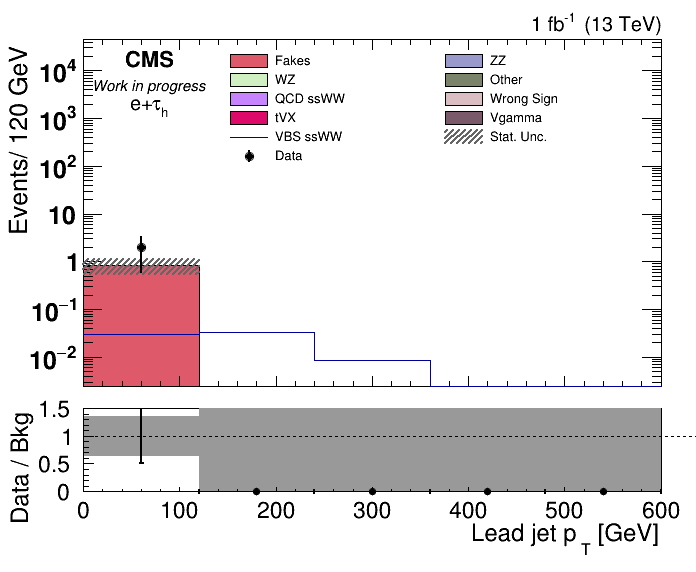

In [16]:
%%time

lep_ = 'electron'
reg_ = 'ltau'
variabile_ = variables[0] 
#samples_ = sampless
cut_tag_ = ""
syst_ = "" 
lumi = 41.53


hdata = h['Data'][variabile_._name]['etau']
hsig = h['VBS ssWW'][variabile_._name]['etau']

lep_tag = "e+"
cmsreg = "#tau_{h}" 
cmsreg = lep_tag + cmsreg 

stackname = "stack"
canvasname = "canvas"
blind = False

h_err = ROOT.TH1F()

ROOT.gROOT.SetStyle('Plain')
ROOT.gStyle.SetPalette(1)
ROOT.gStyle.SetOptStat(0)
ROOT.TH1.SetDefaultSumw2()

# Draw stack with MC contributions
stack = ROOT.THStack(stackname, variabile_._name)
leg_stack = ROOT.TLegend(0.32,0.58,0.93,0.87)

colors = [(222, 90, 106), (155, 152, 204), (208, 240, 193), (122, 130, 106), (200, 131, 274), (218, 190, 193), (222, 10, 106), (122, 90, 106)]

i = 0
for v in h.keys():
    if v == 'Data' or v == 'VBS ssWW':
        continue
    h_ = h[v][variabile_._name]['etau']
    h_.SetLineWidth(1)
    h_.SetLineColor(1)
    color = colors[i]
    h_.SetFillColor(ROOT.TColor.GetColor(*color))
    stack.Add(h_.GetValue())
    leg_stack.AddEntry(h_.GetValue(), v, "f")
    i +=1

leg_stack.SetNColumns(2)
leg_stack.SetFillColor(0)
leg_stack.SetFillStyle(0)
leg_stack.SetTextFont(42)
leg_stack.SetBorderSize(0)
leg_stack.SetTextSize(0.035)

# Create canvas
c1 = ROOT.TCanvas(canvasname,"c1",50,50,700,600)
c1.SetFillColor(0)
c1.SetBorderMode(0)
c1.SetFrameFillStyle(0)
c1.SetFrameBorderMode(0)
c1.SetLeftMargin( 0.12 )
c1.SetRightMargin( 0.9 )
c1.SetTopMargin( 1 )
c1.SetBottomMargin(-1)
c1.SetTickx(1)
c1.SetTicky(1)
c1.cd()

pad1= ROOT.TPad("pad1", "pad1", 0, 0.31 , 1, 1)
pad1.SetTopMargin(0.1)
pad1.SetBottomMargin(0.02)
pad1.SetLeftMargin(0.12)
pad1.SetRightMargin(0.05)
pad1.SetBorderMode(0)
pad1.SetTickx(1)
pad1.SetTicky(1)
pad1.Draw()
pad1.cd()

if not blind:
    maximum = max(stack.GetMaximum(),hdata.GetMaximum())
else:
    maximum = stack.GetMaximum()
logscale = True # False #
if(logscale) and stack.GetStack().Last().Integral()>0.:
    stack.SetMinimum(0.01)
    pad1.SetLogy()
    stack.SetMaximum(maximum*10000)
else:
    stack.SetMaximum(maximum*1.6)

stack.Draw("HIST")
    
if not variabile_._iscustom:
    step = float(variabile_._xmax - variabile_._xmin)/float(variabile_._nbins)
    #print(str(step))
    if "GeV" in variabile_._title:
        if step.is_integer():
            ytitle = "Events/ %.0f GeV" %step
        else:
            ytitle = "Events / %.2f GeV" %step
    else:
       if step.is_integer():
           ytitle = "Events / %.0f units" %step
       else:
           ytitle = "Events / %.2f units" %step
else:
    if "GeV" in variabile_._title:
        ytitle = "Events / GeV"
    else:
        ytitle = "Events / a.u"

print(stack)
stack.GetYaxis().SetTitle(ytitle)
stack.GetYaxis().SetTitleFont(42)
stack.GetXaxis().SetLabelOffset(1.8)
stack.GetYaxis().SetTitleOffset(0.85)
stack.GetXaxis().SetLabelSize(0.15)
stack.GetYaxis().SetLabelSize(0.07)
stack.GetYaxis().SetTitleSize(0.07)
stack.SetTitle("")

#hsig.Scale(1000)
print("VBS ssWW")
hsig.Draw("hist same")
leg_stack.AddEntry(hsig.GetValue(), "VBS ssWW", "l")

h_err = stack.GetStack().Last().Clone("h_err")
h_err.SetLineWidth(100)
h_err.SetFillStyle(3154)
h_err.SetMarkerSize(0)
h_err.SetFillColor(ROOT.kGray+2)
h_err.Draw("e2same0")
leg_stack.AddEntry(h_err, "Stat. Unc.", "f")

print("Data")
leg_stack.AddEntry(hdata.GetValue(), "Data", "ep")
leg_stack.Draw("same")

# Draw data
hdata.SetMarkerStyle(20)
hdata.SetMarkerSize(1.2)
hdata.SetLineWidth(2)
hdata.SetLineColor(ROOT.kBlack)
#hdata.Draw("E SAME")
hdata.Draw("eSAMEpx0")
 
lumi = 1
lumi_scale = 21

CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ""

print("lep_tag: ", lep_tag)
lumi_sqrtS = "%s fb^{-1}  (13 TeV)"%(lumi)

iPeriod = 0
iPos = 11
CMS_lumi(pad1, lumi_sqrtS, iPos, str(cmsreg))

hratio = stack.GetStack().Last()

c1.cd()
pad2= ROOT.TPad("pad2", "pad2", 0, 0.01 , 1, 0.30)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.45)
pad2.SetLeftMargin(0.12)
pad2.SetRightMargin(0.05)
ROOT.gStyle.SetHatchesSpacing(2)
ROOT.gStyle.SetHatchesLineWidth(2)
c1.cd()
pad2.Draw()
pad2.cd()
ratio = hdata.Clone("ratio")
ratio.SetLineColor(ROOT.kBlack)
ratio.SetMaximum(10)
ratio.SetMinimum(0)
ratio.Sumw2()
ratio.SetStats(0)

ratio.Divide(hratio)
ratio.SetMarkerStyle(20)
ratio.SetMarkerSize(0.9)
ratio.Draw("epx0e0")
ratio.SetTitle("")

h_bkg_err = hratio.Clone("h_err")
h_bkg_err.Reset()
h_bkg_err.Sumw2()
for i in range(1,hratio.GetNbinsX()+1):
    h_bkg_err.SetBinContent(i,1)
    if(hratio.GetBinContent(i)):
        h_bkg_err.SetBinError(i, (hratio.GetBinError(i)/hratio.GetBinContent(i)))
    else:
        h_bkg_err.SetBinError(i, 10^(-99))
h_bkg_err.SetLineWidth(100)

h_bkg_err.SetMarkerSize(0)
h_bkg_err.SetFillColor(ROOT.kGray+1)
h_bkg_err.Draw("e20same")

if not variabile_._iscustom:
    xmin = variabile_._xmin
else:
    xmin = variabile_._xmin[0]
f1 = ROOT.TLine(xmin, 1., variabile_._xmax,1.)
xmin = 0
xmax = 2000
f1 = ROOT.TLine(xmin, 1., xmax,1.)
f1.SetLineColor(ROOT.kBlack)
f1.SetLineStyle(ROOT.kDashed)
f1.Draw("same")

ratio.GetYaxis().SetTitle("Data / Bkg")
ratio.GetYaxis().SetNdivisions(503)
ratio.GetXaxis().SetLabelFont(42)
ratio.GetYaxis().SetLabelFont(42)
ratio.GetXaxis().SetTitleFont(42)
ratio.GetYaxis().SetTitleFont(42)
ratio.GetXaxis().SetTitleOffset(1.1)
ratio.GetYaxis().SetTitleOffset(0.35)
ratio.GetXaxis().SetLabelSize(0.15)
ratio.GetYaxis().SetLabelSize(0.15)
ratio.GetXaxis().SetTitleSize(0.16)
ratio.GetYaxis().SetTitleSize(0.16)
ratio.GetYaxis().SetRangeUser(0,1.5)
ratio.GetXaxis().SetTitle(variabile_._title)
ratio.GetXaxis().SetLabelOffset(0.04)
ratio.GetYaxis().SetLabelOffset(0.02)
ratio.Draw("epx0e0same")

c1.cd()
c1.RedrawAxis()
pad2.RedrawAxis()
c1.Update()

c1.Draw()

# Plots for muon + tau final state

{}
VBS ssWW
Data
lep_tag:  #mu+


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


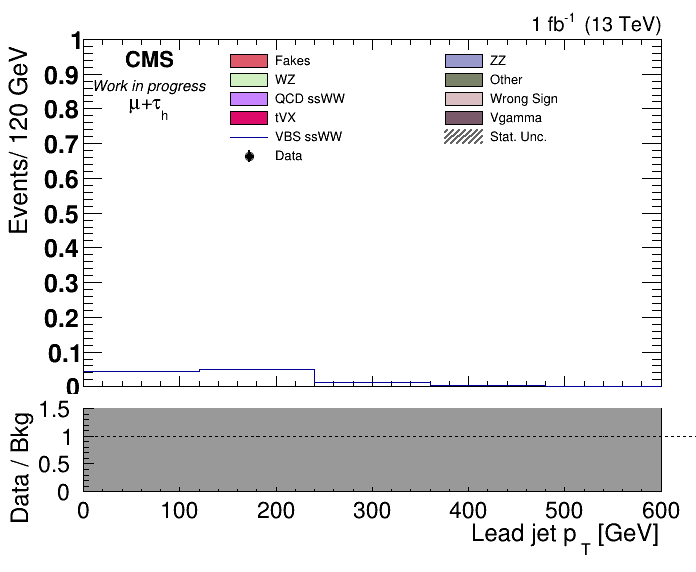

In [17]:
lep_ = 'muon'
reg_ = 'ltau'
variabile_ = variables[0] 
#samples_ = sampless
cut_tag_ = ""
syst_ = "" 
lumi = 41.53


hdata = h['Data'][variabile_._name]['mutau']
hsig = h['VBS ssWW'][variabile_._name]['mutau']

lep_tag = "#mu+"
cmsreg = "#tau_{h}" 
cmsreg = lep_tag + cmsreg 

stackname = "stack"
canvasname = "canvas"
blind = False

h_err = ROOT.TH1F()

ROOT.gROOT.SetStyle('Plain')
ROOT.gStyle.SetPalette(1)
ROOT.gStyle.SetOptStat(0)
ROOT.TH1.SetDefaultSumw2()

# Draw stack with MC contributions
stack = ROOT.THStack(stackname, variabile_._name)
leg_stack = ROOT.TLegend(0.32,0.58,0.93,0.87)

colors = [(222, 90, 106), (155, 152, 204), (208, 240, 193), (122, 130, 106), (200, 131, 274), (218, 190, 193), (222, 10, 106), (122, 90, 106)]

i = 0
for v in h.keys():
    if v == 'Data' or v == 'VBS ssWW':
        continue
    h_ = h[v][variabile_._name]['mutau']
    h_.SetLineWidth(1)
    h_.SetLineColor(1)
    color = colors[i]
    h_.SetFillColor(ROOT.TColor.GetColor(*color))
    stack.Add(h_.GetValue())
    leg_stack.AddEntry(h_.GetValue(), v, "f")
    i +=1

leg_stack.SetNColumns(2)
leg_stack.SetFillColor(0)
leg_stack.SetFillStyle(0)
leg_stack.SetTextFont(42)
leg_stack.SetBorderSize(0)
leg_stack.SetTextSize(0.035)

# Create canvas
c1 = ROOT.TCanvas(canvasname,"c1",50,50,700,600)
c1.SetFillColor(0)
c1.SetBorderMode(0)
c1.SetFrameFillStyle(0)
c1.SetFrameBorderMode(0)
c1.SetLeftMargin( 0.12 )
c1.SetRightMargin( 0.9 )
c1.SetTopMargin( 1 )
c1.SetBottomMargin(-1)
c1.SetTickx(1)
c1.SetTicky(1)
c1.cd()

pad1= ROOT.TPad("pad1", "pad1", 0, 0.31 , 1, 1)
pad1.SetTopMargin(0.1)
pad1.SetBottomMargin(0.02)
pad1.SetLeftMargin(0.12)
pad1.SetRightMargin(0.05)
pad1.SetBorderMode(0)
pad1.SetTickx(1)
pad1.SetTicky(1)
pad1.Draw()
pad1.cd()

if not blind:
    maximum = max(stack.GetMaximum(),hdata.GetMaximum())
else:
    maximum = stack.GetMaximum()
logscale = True # False #
if(logscale) and stack.GetStack().Last().Integral()>0.:
    stack.SetMinimum(0.01)
    pad1.SetLogy()
    stack.SetMaximum(maximum*10000)
else:
    stack.SetMaximum(maximum*1.6)

stack.Draw("HIST")
    
if not variabile_._iscustom:
    step = float(variabile_._xmax - variabile_._xmin)/float(variabile_._nbins)
    #print(str(step))
    if "GeV" in variabile_._title:
        if step.is_integer():
            ytitle = "Events/ %.0f GeV" %step
        else:
            ytitle = "Events / %.2f GeV" %step
    else:
       if step.is_integer():
           ytitle = "Events / %.0f units" %step
       else:
           ytitle = "Events / %.2f units" %step
else:
    if "GeV" in variabile_._title:
        ytitle = "Events / GeV"
    else:
        ytitle = "Events / a.u"

print(stack)
stack.GetYaxis().SetTitle(ytitle)
stack.GetYaxis().SetTitleFont(42)
stack.GetXaxis().SetLabelOffset(1.8)
stack.GetYaxis().SetTitleOffset(0.85)
stack.GetXaxis().SetLabelSize(0.15)
stack.GetYaxis().SetLabelSize(0.07)
stack.GetYaxis().SetTitleSize(0.07)
stack.SetTitle("")

#hsig.Scale(1000)
print("VBS ssWW")
hsig.Draw("hist same")
leg_stack.AddEntry(hsig.GetValue(), "VBS ssWW", "l")

h_err = stack.GetStack().Last().Clone("h_err")
h_err.SetLineWidth(100)
h_err.SetFillStyle(3154)
h_err.SetMarkerSize(0)
h_err.SetFillColor(ROOT.kGray+2)
h_err.Draw("e2same0")
leg_stack.AddEntry(h_err, "Stat. Unc.", "f")

print("Data")
leg_stack.AddEntry(hdata.GetValue(), "Data", "ep")
leg_stack.Draw("same")

# Draw data
hdata.SetMarkerStyle(20)
hdata.SetMarkerSize(1.2)
hdata.SetLineWidth(2)
hdata.SetLineColor(ROOT.kBlack)
#hdata.Draw("E SAME")
hdata.Draw("eSAMEpx0")
 
lumi = 1
lumi_scale = 21

CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ""

print("lep_tag: ", lep_tag)
lumi_sqrtS = "%s fb^{-1}  (13 TeV)"%(lumi)

iPeriod = 0
iPos = 11
CMS_lumi(pad1, lumi_sqrtS, iPos, str(cmsreg))

hratio = stack.GetStack().Last()

c1.cd()
pad2= ROOT.TPad("pad2", "pad2", 0, 0.01 , 1, 0.30)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.45)
pad2.SetLeftMargin(0.12)
pad2.SetRightMargin(0.05)
ROOT.gStyle.SetHatchesSpacing(2)
ROOT.gStyle.SetHatchesLineWidth(2)
c1.cd()
pad2.Draw()
pad2.cd()
ratio = hdata.Clone("ratio")
ratio.SetLineColor(ROOT.kBlack)
ratio.SetMaximum(10)
ratio.SetMinimum(0)
ratio.Sumw2()
ratio.SetStats(0)

ratio.Divide(hratio)
ratio.SetMarkerStyle(20)
ratio.SetMarkerSize(0.9)
ratio.Draw("epx0e0")
ratio.SetTitle("")

h_bkg_err = hratio.Clone("h_err")
h_bkg_err.Reset()
h_bkg_err.Sumw2()
for i in range(1,hratio.GetNbinsX()+1):
    h_bkg_err.SetBinContent(i,1)
    if(hratio.GetBinContent(i)):
        h_bkg_err.SetBinError(i, (hratio.GetBinError(i)/hratio.GetBinContent(i)))
    else:
        h_bkg_err.SetBinError(i, 10^(-99))
h_bkg_err.SetLineWidth(100)

h_bkg_err.SetMarkerSize(0)
h_bkg_err.SetFillColor(ROOT.kGray+1)
h_bkg_err.Draw("e20same")

if not variabile_._iscustom:
    xmin = variabile_._xmin
else:
    xmin = variabile_._xmin[0]
f1 = ROOT.TLine(xmin, 1., variabile_._xmax,1.)
xmin = 0
xmax = 2000
f1 = ROOT.TLine(xmin, 1., xmax,1.)
f1.SetLineColor(ROOT.kBlack)
f1.SetLineStyle(ROOT.kDashed)
f1.Draw("same")

ratio.GetYaxis().SetTitle("Data / Bkg")
ratio.GetYaxis().SetNdivisions(503)
ratio.GetXaxis().SetLabelFont(42)
ratio.GetYaxis().SetLabelFont(42)
ratio.GetXaxis().SetTitleFont(42)
ratio.GetYaxis().SetTitleFont(42)
ratio.GetXaxis().SetTitleOffset(1.1)
ratio.GetYaxis().SetTitleOffset(0.35)
ratio.GetXaxis().SetLabelSize(0.15)
ratio.GetYaxis().SetLabelSize(0.15)
ratio.GetXaxis().SetTitleSize(0.16)
ratio.GetYaxis().SetTitleSize(0.16)
ratio.GetYaxis().SetRangeUser(0,1.5)
ratio.GetXaxis().SetTitle(variabile_._title)
ratio.GetXaxis().SetLabelOffset(0.04)
ratio.GetYaxis().SetLabelOffset(0.02)
ratio.Draw("epx0e0same")

c1.cd()
c1.RedrawAxis()
pad2.RedrawAxis()
c1.Update()

c1.Draw()